# VirtualiZarr Experiments

This notebook more or less follows https://virtualizarr.readthedocs.io/en/latest/usage.html
as it stood in mid-Oct 2024 to explore the use of virtual datasets with the SalishSeaCast model results.

It uses the development HEAD of the VirtualiZarr repo on GitHub,
installed in the environment with `python -m pip install -e ...`.


In [10]:
import os
from pathlib import Path

import arrow
import virtualizarr
import xarray

In [2]:
import sys

import bottleneck
import h5netcdf
import h5py
import matplotlib
import numpy

print(f"Python {sys.version=}")
print(f"{numpy.__version__=}")
print(f"{xarray.__version__=}")
print(f"{bottleneck.__version__=}")
print(f"{h5netcdf.__version__=}")
print(f"{h5py.__version__=}")
print(f"{virtualizarr.__version__=}")
print(f"{matplotlib.__version__=}")
print(f"{arrow.__version__=}")

Python sys.version='3.12.7 | packaged by conda-forge | (main, Oct  4 2024, 16:05:46) [GCC 13.3.0]'
numpy.__version__='2.1.2'
xarray.__version__='2024.9.0'
bottleneck.__version__='1.4.2'
h5netcdf.__version__='1.4.0'
h5py.__version__='3.12.1'
virtualizarr.__version__='1.0.1.dev30+g29ca4ac'
matplotlib.__version__='3.9.2'
arrow.__version__='1.3.0'


In [3]:
results_archive = Path("/results2/SalishSea/nowcast-green.202111/")

Load manifest arrays from a SalishSeaCast 1h results file:

In [15]:
nc_path = results_archive / Path("12oct24", "SalishSea_1h_20241012_20241012_grid_T.nc")
drop_vars = [
    "time_centered",
    "time_centered_bounds",
    "time_counter_bounds",
    "bounds_nav_lat",
    "bounds_nav_lon",
    "deptht_bounds",
    "nav_lat",
    "nav_lon",
    "area",
]
# **IMPORTANT**: filepath must presently be a string, Path() instances fail confusingly in kerchunk
# TypeError: argument should be a str or an os.PathLike object where __fspath__ returns a str
vds = virtualizarr.open_virtual_dataset(os.fspath(nc_path), drop_variables=drop_vars, indexes={})

vds

<xarray.Dataset> Size: 6GB
Dimensions:       (time_counter: 24, deptht: 40, y: 898, x: 398)
Coordinates:
    time_counter  (time_counter) float64 192B ManifestArray<shape=(24,), dtyp...
    deptht        (deptht) float32 160B ManifestArray<shape=(40,), dtype=floa...
Dimensions without coordinates: y, x
Data variables:
    e3t           (time_counter, deptht, y, x) float32 1GB ManifestArray<shap...
    sossheig      (time_counter, y, x) float32 34MB ManifestArray<shape=(24, ...
    vosaline      (time_counter, deptht, y, x) float32 1GB ManifestArray<shap...
    sigma_theta   (time_counter, deptht, y, x) float32 1GB ManifestArray<shap...
    votemper      (time_counter, deptht, y, x) float32 1GB ManifestArray<shap...
Attributes:
    Conventions:  CF-1.6
    description:  physics tracers and VVL layer thicknesses
    name:         SalishSea_1h_20241012_20241012_grid_T
    timeStamp:    2024-Oct-12 19:04:02 GMT
    title:        physics tracers and VVL layer thicknesses
    uuid:         151457db-fb33-443d-9d80-bde83be66b8b

Manifest arrays are offsets, lengths and file paths to access the chunks in the dataset via binary reads:

In [21]:
marr = vds.e3t.data
marr

ManifestArray<shape=(24, 40, 898, 398), dtype=float32, chunks=(1, 40, 898, 398)>

In [22]:
manifest = marr.manifest
manifest

ChunkManifest<shape=(24, 1, 1, 1)>

In [23]:
manifest.dict()

{'0.0.0.0': {'path': '/results2/SalishSea/nowcast-green.202111/12oct24/SalishSea_1h_20241012_20241012_grid_T.nc',
  'offset': 2173611,
  'length': 6909065},
 '1.0.0.0': {'path': '/results2/SalishSea/nowcast-green.202111/12oct24/SalishSea_1h_20241012_20241012_grid_T.nc',
  'offset': 31567287,
  'length': 6802561},
 '2.0.0.0': {'path': '/results2/SalishSea/nowcast-green.202111/12oct24/SalishSea_1h_20241012_20241012_grid_T.nc',
  'offset': 61105527,
  'length': 6694174},
 '3.0.0.0': {'path': '/results2/SalishSea/nowcast-green.202111/12oct24/SalishSea_1h_20241012_20241012_grid_T.nc',
  'offset': 90521803,
  'length': 6607529},
 '4.0.0.0': {'path': '/results2/SalishSea/nowcast-green.202111/12oct24/SalishSea_1h_20241012_20241012_grid_T.nc',
  'offset': 119834924,
  'length': 6570834},
 '5.0.0.0': {'path': '/results2/SalishSea/nowcast-green.202111/12oct24/SalishSea_1h_20241012_20241012_grid_T.nc',
  'offset': 149091574,
  'length': 6505494},
 '6.0.0.0': {'path': '/results2/SalishSea/nowcast-g

In [24]:
marr.zarray

ZArray(shape=(24, 40, 898, 398), chunks=(1, 40, 898, 398), dtype=dtype('float32'), fill_value=1.0000000200408773e+20, order='C', compressor=None, filters=[{'elementsize': 4, 'id': 'shuffle'}, {'id': 'zlib', 'level': 4}], zarr_format=2)

Concatenate consecutive day's 1h `grid_T` files into a virtual dataset of manifest arrays:

In [28]:
nc_paths = [
    results_archive / Path("12oct24", "SalishSea_1h_20241012_20241012_grid_T.nc"),
    results_archive / Path("13oct24", "SalishSea_1h_20241013_20241013_grid_T.nc"),
]
drop_vars = [
    "time_centered",
    "time_centered_bounds",
    "time_counter_bounds",
    "bounds_nav_lat",
    "bounds_nav_lon",
    "deptht_bounds",
    "nav_lat",
    "nav_lon",
    "area",
]
# **IMPORTANT**: filepath must presently be a string, Path() instances fail confusingly in kerchunk
# TypeError: argument should be a str or an os.PathLike object where __fspath__ returns a str
vdss = [
    virtualizarr.open_virtual_dataset(os.fspath(nc_path), drop_variables=drop_vars, indexes={})
     for nc_path in nc_paths
]

combined_vds = xarray.concat(vdss, dim="time_counter", coords="minimal", compat="override")
combined_vds

<xarray.Dataset> Size: 11GB
Dimensions:       (time_counter: 48, deptht: 40, y: 898, x: 398)
Coordinates:
    time_counter  (time_counter) float64 384B ManifestArray<shape=(48,), dtyp...
    deptht        (deptht) float32 160B ManifestArray<shape=(40,), dtype=floa...
Dimensions without coordinates: y, x
Data variables:
    e3t           (time_counter, deptht, y, x) float32 3GB ManifestArray<shap...
    sossheig      (time_counter, y, x) float32 69MB ManifestArray<shape=(48, ...
    vosaline      (time_counter, deptht, y, x) float32 3GB ManifestArray<shap...
    sigma_theta   (time_counter, deptht, y, x) float32 3GB ManifestArray<shap...
    votemper      (time_counter, deptht, y, x) float32 3GB ManifestArray<shap...
Attributes:
    Conventions:  CF-1.6
    description:  physics tracers and VVL layer thicknesses
    name:         SalishSea_1h_20241012_20241012_grid_T
    timeStamp:    2024-Oct-12 19:04:02 GMT
    title:        physics tracers and VVL layer thicknesses
    uuid:         151457db-fb33-443d-9d80-bde83be66b8b

Merge variables from one day's `grid_T` and `chem_T` files into a virtual dataset of manifest arrays;
i.e. abstract away the fact that physics and chemistry tracers are stored in different files:

In [32]:
nc_paths = [
    results_archive / Path("12oct24", "SalishSea_1h_20241012_20241012_grid_T.nc"),
    results_archive / Path("12oct24", "SalishSea_1h_20241012_20241012_chem_T.nc"),
]
drop_vars = [
    "time_centered",
    "time_centered_bounds",
    "time_counter_bounds",
    "bounds_nav_lat",
    "bounds_nav_lon",
    "deptht_bounds",
    "nav_lat",
    "nav_lon",
    "area",
]
# **IMPORTANT**: filepath must presently be a string, Path() instances fail confusingly in kerchunk
# TypeError: argument should be a str or an os.PathLike object where __fspath__ returns a str
vdss = [
    virtualizarr.open_virtual_dataset(os.fspath(nc_path), drop_variables=drop_vars, indexes={})
     for nc_path in nc_paths
]

merged_vds = xarray.merge(vdss, compat="override")
merged_vds

<xarray.Dataset> Size: 12GB
Dimensions:                     (time_counter: 24, deptht: 40, y: 898, x: 398)
Coordinates:
    time_counter                (time_counter) float64 192B ManifestArray<sha...
    deptht                      (deptht) float32 160B ManifestArray<shape=(40...
Dimensions without coordinates: y, x
Data variables:
    e3t                         (time_counter, deptht, y, x) float32 1GB Mani...
    sossheig                    (time_counter, y, x) float32 34MB ManifestArr...
    vosaline                    (time_counter, deptht, y, x) float32 1GB Mani...
    sigma_theta                 (time_counter, deptht, y, x) float32 1GB Mani...
    votemper                    (time_counter, deptht, y, x) float32 1GB Mani...
    dissolved_inorganic_carbon  (time_counter, deptht, y, x) float32 1GB Mani...
    CO2_flux                    (time_counter, y, x) float32 34MB ManifestArr...
    total_alkalinity            (time_counter, deptht, y, x) float32 1GB Mani...
    PAR                         (time_counter, deptht, y, x) float32 1GB Mani...
    turbidity                   (time_counter, deptht, y, x) float32 1GB Mani...
    dissolved_oxygen            (time_counter, deptht, y, x) float32 1GB Mani...
Attributes:
    Conventions:  CF-1.6
    description:  physics tracers and VVL layer thicknesses
    name:         SalishSea_1h_20241012_20241012_grid_T
    timeStamp:    2024-Oct-12 19:04:02 GMT
    title:        physics tracers and VVL layer thicknesses
    uuid:         151457db-fb33-443d-9d80-bde83be66b8b

In [33]:
merged_vds.e3t.data.manifest.dict()

{'0.0.0.0': {'path': '/results2/SalishSea/nowcast-green.202111/12oct24/SalishSea_1h_20241012_20241012_grid_T.nc',
  'offset': 2173611,
  'length': 6909065},
 '1.0.0.0': {'path': '/results2/SalishSea/nowcast-green.202111/12oct24/SalishSea_1h_20241012_20241012_grid_T.nc',
  'offset': 31567287,
  'length': 6802561},
 '2.0.0.0': {'path': '/results2/SalishSea/nowcast-green.202111/12oct24/SalishSea_1h_20241012_20241012_grid_T.nc',
  'offset': 61105527,
  'length': 6694174},
 '3.0.0.0': {'path': '/results2/SalishSea/nowcast-green.202111/12oct24/SalishSea_1h_20241012_20241012_grid_T.nc',
  'offset': 90521803,
  'length': 6607529},
 '4.0.0.0': {'path': '/results2/SalishSea/nowcast-green.202111/12oct24/SalishSea_1h_20241012_20241012_grid_T.nc',
  'offset': 119834924,
  'length': 6570834},
 '5.0.0.0': {'path': '/results2/SalishSea/nowcast-green.202111/12oct24/SalishSea_1h_20241012_20241012_grid_T.nc',
  'offset': 149091574,
  'length': 6505494},
 '6.0.0.0': {'path': '/results2/SalishSea/nowcast-g

In [34]:
merged_vds.PAR.data.manifest.dict()

{'0.0.0.0': {'path': '/results2/SalishSea/nowcast-green.202111/12oct24/SalishSea_1h_20241012_20241012_chem_T.nc',
  'offset': 33539088,
  'length': 12472698},
 '1.0.0.0': {'path': '/results2/SalishSea/nowcast-green.202111/12oct24/SalishSea_1h_20241012_20241012_chem_T.nc',
  'offset': 77365871,
  'length': 12552651},
 '2.0.0.0': {'path': '/results2/SalishSea/nowcast-green.202111/12oct24/SalishSea_1h_20241012_20241012_chem_T.nc',
  'offset': 121597136,
  'length': 12559235},
 '3.0.0.0': {'path': '/results2/SalishSea/nowcast-green.202111/12oct24/SalishSea_1h_20241012_20241012_chem_T.nc',
  'offset': 165823489,
  'length': 12617424},
 '4.0.0.0': {'path': '/results2/SalishSea/nowcast-green.202111/12oct24/SalishSea_1h_20241012_20241012_chem_T.nc',
  'offset': 210093610,
  'length': 835275},
 '5.0.0.0': {'path': '/results2/SalishSea/nowcast-green.202111/12oct24/SalishSea_1h_20241012_20241012_chem_T.nc',
  'offset': 242566942,
  'length': 835275},
 '6.0.0.0': {'path': '/results2/SalishSea/nowc

Combine variables from multiple day's `grid_T` and `chem_T` files into a virtual dataset of manifest arrays;
i.e. combine the concatenation and merge operations above:

In [38]:
nc_paths = [
    results_archive / Path("12oct24", "SalishSea_1h_20241012_20241012_grid_T.nc"),
    results_archive / Path("12oct24", "SalishSea_1h_20241012_20241012_chem_T.nc"),
    results_archive / Path("13oct24", "SalishSea_1h_20241013_20241013_grid_T.nc"),
    results_archive / Path("13oct24", "SalishSea_1h_20241013_20241013_chem_T.nc"),
]
drop_vars = [
    "time_centered",
    "time_centered_bounds",
    "time_counter_bounds",
    "bounds_nav_lat",
    "bounds_nav_lon",
    "deptht_bounds",
    "nav_lat",
    "nav_lon",
    "area",
]
# **IMPORTANT**: filepath must presently be a string, Path() instances fail confusingly in kerchunk
# TypeError: argument should be a str or an os.PathLike object where __fspath__ returns a str
vdss = [
    virtualizarr.open_virtual_dataset(os.fspath(nc_path), drop_variables=drop_vars, indexes={})
     for nc_path in nc_paths
]

combined_vds = xarray.combine_nested([[vdss[0], vdss[1]], [vdss[2], vdss[3]]], concat_dim=["time_counter", None], compat="override", coords="minimal")
combined_vds

<xarray.Dataset> Size: 25GB
Dimensions:                     (time_counter: 48, deptht: 40, y: 898, x: 398)
Coordinates:
    time_counter                (time_counter) float64 384B ManifestArray<sha...
    deptht                      (deptht) float32 160B ManifestArray<shape=(40...
Dimensions without coordinates: y, x
Data variables:
    e3t                         (time_counter, deptht, y, x) float32 3GB Mani...
    sossheig                    (time_counter, y, x) float32 69MB ManifestArr...
    vosaline                    (time_counter, deptht, y, x) float32 3GB Mani...
    sigma_theta                 (time_counter, deptht, y, x) float32 3GB Mani...
    votemper                    (time_counter, deptht, y, x) float32 3GB Mani...
    dissolved_inorganic_carbon  (time_counter, deptht, y, x) float32 3GB Mani...
    CO2_flux                    (time_counter, y, x) float32 69MB ManifestArr...
    total_alkalinity            (time_counter, deptht, y, x) float32 3GB Mani...
    PAR                         (time_counter, deptht, y, x) float32 3GB Mani...
    turbidity                   (time_counter, deptht, y, x) float32 3GB Mani...
    dissolved_oxygen            (time_counter, deptht, y, x) float32 3GB Mani...

In [42]:
combined_vds.e3t.data.manifest.dict()

{'0.0.0.0': {'path': '/results2/SalishSea/nowcast-green.202111/12oct24/SalishSea_1h_20241012_20241012_grid_T.nc',
  'offset': 2173611,
  'length': 6909065},
 '1.0.0.0': {'path': '/results2/SalishSea/nowcast-green.202111/12oct24/SalishSea_1h_20241012_20241012_grid_T.nc',
  'offset': 31567287,
  'length': 6802561},
 '2.0.0.0': {'path': '/results2/SalishSea/nowcast-green.202111/12oct24/SalishSea_1h_20241012_20241012_grid_T.nc',
  'offset': 61105527,
  'length': 6694174},
 '3.0.0.0': {'path': '/results2/SalishSea/nowcast-green.202111/12oct24/SalishSea_1h_20241012_20241012_grid_T.nc',
  'offset': 90521803,
  'length': 6607529},
 '4.0.0.0': {'path': '/results2/SalishSea/nowcast-green.202111/12oct24/SalishSea_1h_20241012_20241012_grid_T.nc',
  'offset': 119834924,
  'length': 6570834},
 '5.0.0.0': {'path': '/results2/SalishSea/nowcast-green.202111/12oct24/SalishSea_1h_20241012_20241012_grid_T.nc',
  'offset': 149091574,
  'length': 6505494},
 '6.0.0.0': {'path': '/results2/SalishSea/nowcast-g

In [43]:
combined_vds.PAR.data.manifest.dict()

{'0.0.0.0': {'path': '/results2/SalishSea/nowcast-green.202111/12oct24/SalishSea_1h_20241012_20241012_chem_T.nc',
  'offset': 33539088,
  'length': 12472698},
 '1.0.0.0': {'path': '/results2/SalishSea/nowcast-green.202111/12oct24/SalishSea_1h_20241012_20241012_chem_T.nc',
  'offset': 77365871,
  'length': 12552651},
 '2.0.0.0': {'path': '/results2/SalishSea/nowcast-green.202111/12oct24/SalishSea_1h_20241012_20241012_chem_T.nc',
  'offset': 121597136,
  'length': 12559235},
 '3.0.0.0': {'path': '/results2/SalishSea/nowcast-green.202111/12oct24/SalishSea_1h_20241012_20241012_chem_T.nc',
  'offset': 165823489,
  'length': 12617424},
 '4.0.0.0': {'path': '/results2/SalishSea/nowcast-green.202111/12oct24/SalishSea_1h_20241012_20241012_chem_T.nc',
  'offset': 210093610,
  'length': 835275},
 '5.0.0.0': {'path': '/results2/SalishSea/nowcast-green.202111/12oct24/SalishSea_1h_20241012_20241012_chem_T.nc',
  'offset': 242566942,
  'length': 835275},
 '6.0.0.0': {'path': '/results2/SalishSea/nowc

Merge variables from one day's `grid_T` and `grid_U` files into a virtual dataset of manifest arrays;
i.e. abstract away the fact that physics tracers and u-velocity are stored in different files with different depth coordinates:

In [45]:
nc_paths = [
    results_archive / Path("12oct24", "SalishSea_1h_20241012_20241012_grid_T.nc"),
    results_archive / Path("12oct24", "SalishSea_1h_20241012_20241012_grid_U.nc"),
]
drop_vars = [
    "time_centered",
    "time_centered_bounds",
    "time_counter_bounds",
    "bounds_nav_lat",
    "bounds_nav_lon",
    "deptht_bounds",
    "depthu_bounds",
    "nav_lat",
    "nav_lon",
    "area",
]
# **IMPORTANT**: filepath must presently be a string, Path() instances fail confusingly in kerchunk
# TypeError: argument should be a str or an os.PathLike object where __fspath__ returns a str
vdss = [
    virtualizarr.open_virtual_dataset(os.fspath(nc_path), drop_variables=drop_vars, indexes={})
     for nc_path in nc_paths
]

merged_vds = xarray.merge(vdss, compat="override")
merged_vds

<xarray.Dataset> Size: 7GB
Dimensions:       (time_counter: 24, deptht: 40, y: 898, x: 398, depthu: 40)
Coordinates:
    time_counter  (time_counter) float64 192B ManifestArray<shape=(24,), dtyp...
    deptht        (deptht) float32 160B ManifestArray<shape=(40,), dtype=floa...
    depthu        (depthu) float32 160B ManifestArray<shape=(40,), dtype=floa...
Dimensions without coordinates: y, x
Data variables:
    e3t           (time_counter, deptht, y, x) float32 1GB ManifestArray<shap...
    sossheig      (time_counter, y, x) float32 34MB ManifestArray<shape=(24, ...
    vosaline      (time_counter, deptht, y, x) float32 1GB ManifestArray<shap...
    sigma_theta   (time_counter, deptht, y, x) float32 1GB ManifestArray<shap...
    votemper      (time_counter, deptht, y, x) float32 1GB ManifestArray<shap...
    vozocrtx      (time_counter, depthu, y, x) float32 1GB ManifestArray<shap...
Attributes:
    Conventions:  CF-1.6
    description:  physics tracers and VVL layer thicknesses
    name:         SalishSea_1h_20241012_20241012_grid_T
    timeStamp:    2024-Oct-12 19:04:02 GMT
    title:        physics tracers and VVL layer thicknesses
    uuid:         151457db-fb33-443d-9d80-bde83be66b8b

In [46]:
merged_vds.e3t.data.manifest.dict()

{'0.0.0.0': {'path': '/results2/SalishSea/nowcast-green.202111/12oct24/SalishSea_1h_20241012_20241012_grid_T.nc',
  'offset': 2173611,
  'length': 6909065},
 '1.0.0.0': {'path': '/results2/SalishSea/nowcast-green.202111/12oct24/SalishSea_1h_20241012_20241012_grid_T.nc',
  'offset': 31567287,
  'length': 6802561},
 '2.0.0.0': {'path': '/results2/SalishSea/nowcast-green.202111/12oct24/SalishSea_1h_20241012_20241012_grid_T.nc',
  'offset': 61105527,
  'length': 6694174},
 '3.0.0.0': {'path': '/results2/SalishSea/nowcast-green.202111/12oct24/SalishSea_1h_20241012_20241012_grid_T.nc',
  'offset': 90521803,
  'length': 6607529},
 '4.0.0.0': {'path': '/results2/SalishSea/nowcast-green.202111/12oct24/SalishSea_1h_20241012_20241012_grid_T.nc',
  'offset': 119834924,
  'length': 6570834},
 '5.0.0.0': {'path': '/results2/SalishSea/nowcast-green.202111/12oct24/SalishSea_1h_20241012_20241012_grid_T.nc',
  'offset': 149091574,
  'length': 6505494},
 '6.0.0.0': {'path': '/results2/SalishSea/nowcast-g

In [47]:
merged_vds.vozocrtx.data.manifest.dict()

{'0.0.0.0': {'path': '/results2/SalishSea/nowcast-green.202111/12oct24/SalishSea_1h_20241012_20241012_grid_U.nc',
  'offset': 2146957,
  'length': 9365866},
 '1.0.0.0': {'path': '/results2/SalishSea/nowcast-green.202111/12oct24/SalishSea_1h_20241012_20241012_grid_U.nc',
  'offset': 11512823,
  'length': 9386881},
 '2.0.0.0': {'path': '/results2/SalishSea/nowcast-green.202111/12oct24/SalishSea_1h_20241012_20241012_grid_U.nc',
  'offset': 20899704,
  'length': 9395545},
 '3.0.0.0': {'path': '/results2/SalishSea/nowcast-green.202111/12oct24/SalishSea_1h_20241012_20241012_grid_U.nc',
  'offset': 30295249,
  'length': 9412609},
 '4.0.0.0': {'path': '/results2/SalishSea/nowcast-green.202111/12oct24/SalishSea_1h_20241012_20241012_grid_U.nc',
  'offset': 39707858,
  'length': 9424717},
 '5.0.0.0': {'path': '/results2/SalishSea/nowcast-green.202111/12oct24/SalishSea_1h_20241012_20241012_grid_U.nc',
  'offset': 49132575,
  'length': 9423602},
 '6.0.0.0': {'path': '/results2/SalishSea/nowcast-gre

In [52]:
nc_paths = {
    "12oct24": [
        results_archive / Path("12oct24", "SalishSea_1h_20241012_20241012_biol_T.nc"),
        results_archive / Path("12oct24", "SalishSea_1h_20241012_20241012_chem_T.nc"),
        results_archive / Path("12oct24", "SalishSea_1h_20241012_20241012_grid_T.nc"),
        results_archive / Path("12oct24", "SalishSea_1h_20241012_20241012_grid_U.nc"),
        results_archive / Path("12oct24", "SalishSea_1h_20241012_20241012_grid_V.nc"),
        results_archive / Path("12oct24", "SalishSea_1h_20241012_20241012_grid_W.nc"),
    ],
    "13oct24": [
        results_archive / Path("13oct24", "SalishSea_1h_20241013_20241013_biol_T.nc"),
        results_archive / Path("13oct24", "SalishSea_1h_20241013_20241013_chem_T.nc"),
        results_archive / Path("13oct24", "SalishSea_1h_20241013_20241013_grid_T.nc"),
        results_archive / Path("13oct24", "SalishSea_1h_20241013_20241013_grid_U.nc"),
        results_archive / Path("13oct24", "SalishSea_1h_20241013_20241013_grid_V.nc"),
        results_archive / Path("13oct24", "SalishSea_1h_20241013_20241013_grid_W.nc"),
    ],
}
drop_vars = [
    "time_centered",
    "time_centered_bounds",
    "time_counter_bounds",
    "bounds_nav_lat",
    "bounds_nav_lon",
    "deptht_bounds",
    "depthu_bounds",
    "depthv_bounds",
    "depthw_bounds",
    "nav_lat",
    "nav_lon",
    "area",
]
# **IMPORTANT**: filepath must presently be a string, Path() instances fail confusingly in kerchunk
# TypeError: argument should be a str or an os.PathLike object where __fspath__ returns a str
vdss = [
    [
        virtualizarr.open_virtual_dataset(os.fspath(nc_path), drop_variables=drop_vars, indexes={})
        for nc_path in nc_paths[day]
    ] for day in nc_paths
]
combined_vds = xarray.combine_nested(vdss, concat_dim=["time_counter", None], compat="override", coords="minimal")
combined_vds

<xarray.Dataset> Size: 69GB
Dimensions:                       (time_counter: 48, deptht: 40, y: 898,
                                   x: 398, depthu: 40, depthv: 40, depthw: 40)
Coordinates:
    deptht                        (deptht) float32 160B ManifestArray<shape=(...
    time_counter                  (time_counter) float64 384B ManifestArray<s...
    depthu                        (depthu) float32 160B ManifestArray<shape=(...
    depthv                        (depthv) float32 160B ManifestArray<shape=(...
    depthw                        (depthw) float32 160B ManifestArray<shape=(...
Dimensions without coordinates: y, x
Data variables: (12/27)
    diatoms                       (time_counter, deptht, y, x) float32 3GB Ma...
    ammonium                      (time_counter, deptht, y, x) float32 3GB Ma...
    particulate_organic_nitrogen  (time_counter, deptht, y, x) float32 3GB Ma...
    mesozooplankton               (time_counter, deptht, y, x) float32 3GB Ma...
    nitrate                       (time_counter, deptht, y, x) float32 3GB Ma...
    biogenic_silicon              (time_counter, deptht, y, x) float32 3GB Ma...
    ...                            ...
    vozocrtx                      (time_counter, depthu, y, x) float32 3GB Ma...
    vomecrty                      (time_counter, depthv, y, x) float32 3GB Ma...
    vovecrtz                      (time_counter, depthw, y, x) float32 3GB Ma...
    vert_eddy_visc                (time_counter, depthw, y, x) float32 3GB Ma...
    vert_eddy_diff                (time_counter, depthw, y, x) float32 3GB Ma...
    dissipation                   (time_counter, depthw, y, x) float32 3GB Ma...

Store the virtual dataset using parquet:

In [55]:
parq_path = "/media/doug/warehouse/nowcast-green.202111.parq"
combined_vds.virtualize.to_kerchunk(parq_path, format="parquet")

In [60]:
!du -sh /media/doug/warehouse/nowcast-green.202111.parq

272K	/media/doug/warehouse/nowcast-green.202111.parq


Load the dataset with `xarray`:

In [56]:
ds = xarray.open_dataset(parq_path, engine="kerchunk")
ds

<xarray.Dataset> Size: 69GB
Dimensions:                       (time_counter: 48, y: 898, x: 398,
                                   deptht: 40, depthu: 40, depthv: 40,
                                   depthw: 40)
Coordinates:
  * deptht                        (deptht) float32 160B 0.5 1.5 ... 414.5 441.5
  * depthu                        (depthu) float32 160B 0.5 1.5 ... 414.5 441.5
  * depthv                        (depthv) float32 160B 0.5 1.5 ... 414.5 441.5
  * depthw                        (depthw) float32 160B 0.0 1.0 ... 401.1 428.0
  * time_counter                  (time_counter) float64 384B 3.938e+09 ... 3...
Dimensions without coordinates: y, x
Data variables: (12/27)
    CO2_flux                      (time_counter, y, x) float32 69MB ...
    PAR                           (time_counter, deptht, y, x) float32 3GB ...
    ammonium                      (time_counter, deptht, y, x) float32 3GB ...
    biogenic_silicon              (time_counter, deptht, y, x) float32 3GB ...
    diatoms                       (time_counter, deptht, y, x) float32 3GB ...
    dissipation                   (time_counter, depthw, y, x) float32 3GB ...
    ...                            ...
    vert_eddy_visc                (time_counter, depthw, y, x) float32 3GB ...
    vomecrty                      (time_counter, depthv, y, x) float32 3GB ...
    vosaline                      (time_counter, deptht, y, x) float32 3GB ...
    votemper                      (time_counter, deptht, y, x) float32 3GB ...
    vovecrtz                      (time_counter, depthw, y, x) float32 3GB ...
    vozocrtx                      (time_counter, depthu, y, x) float32 3GB ...

All of the metadata and the time coordinate encoding has disappeared! :-(

But we can still get values:

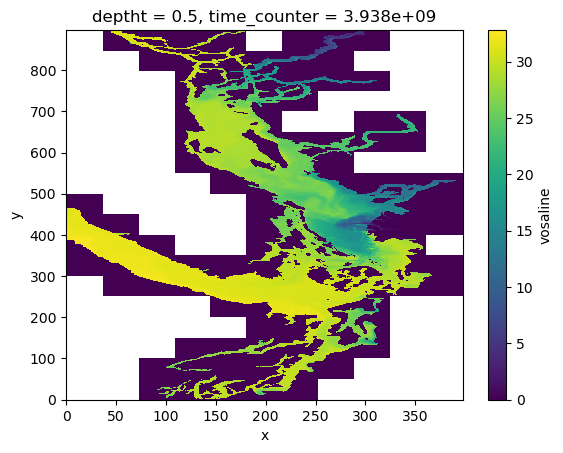

In [76]:
ds.vosaline.isel(time_counter=37, deptht=0).plot()

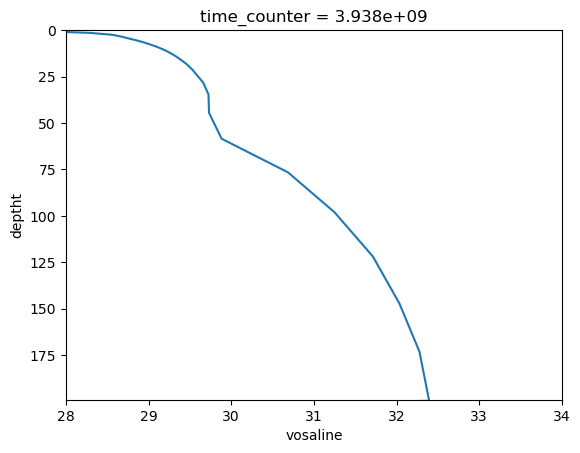

In [77]:
ds.vosaline.isel(time_counter=37, y=350, x=250).plot(y="deptht", yincrease=False, ylim=(199, 0), xlim=(28, 34))